# Homework 2

#### 20145071, Junghoon Seo

#### All codes are writen in Julia 0.5.0.

## Homework 2-1
<img src="./2-1.png">

#### Let me start with data type declaration.

In [1]:
type Point
    x::Float64
    y::Float64
end

data = [Point(0.1, -0.29004996), Point(0.2, -0.56079734), Point(0.3, -0.81401972)]

3-element Array{Point,1}:
 Point(0.1,-0.29005) 
 Point(0.2,-0.560797)
 Point(0.3,-0.81402) 

#### Free cubic spline method by linear algebra approach
<img src="./NumberedEquation1.gif">
#### For detain, please see _Bartels et al. 1998, pp. 12-13_

In [2]:
# Compute D0, D1, ..., Dn
function Compute_D_vector(points::Array)
    n = length(points)
    
    tridiagonal = zeros(Float64, (n, n))
    tridiagonal[1, 1], tridiagonal[1, 2] = 2/(points[2].x-points[1].x), 1/(points[2].x-points[1].x)
    tridiagonal[n, n-1], tridiagonal[n, n] = 1/(points[n].x-points[n-1].x), 2/(points[n].x-points[n-1].x)
    
    for i = 2 : n-1
        tridiagonal[i, i-1], tridiagonal[i, i+1] = 1/(points[i].x-points[i-1].x), 1/(points[i+1].x-points[i].x)
        tridiagonal[i, i] = 2*(1/(points[i].x-points[i-1].x) + 1/(points[i+1].x-points[i].x))
    end
    
    y_vector = zeros(Float64, (n, 1))
    y_vector[1] = 3*((points[2].y-points[1].y)/(points[2].x-points[1].x)^2)
    y_vector[n] = 3*((points[n].y-points[n-1].y)/(points[n].x-points[n-1].x)^2)
    for i = 2 : n-1
        y_vector[i] = 3*((points[i+1].y-points[i].y)/(points[i+1].x-points[i].x)^2 + (points[i].y-points[i-1].y)/(points[i].x-points[i-1].x)^2)
    end
    
    return (inv(tridiagonal)*y_vector)[1:end,1]
end

Compute_D_vector (generic function with 1 method)

In [3]:
D_v = Compute_D_vector(data)

3-element Array{Float64,1}:
 -2.75129
 -2.61985
 -2.48841

In [4]:
function Compute_cubic_spline(x_::Float64, points::Array, D_v::Array)
    n = length(points)
    x_arr = Vector(n)
    for i = 1 : n
        x_arr[i] = points[i].x
    end
    # Which spline is x_ included?
    i = findfirst(x -> x > x_, x_arr) - 1
    
    # Exception for upper boundary
    if(x_ == x_arr[end])
        return points[end].y
    end
    
    a = D_v[i]*(points[i+1].x-points[i].x) - (points[i+1].y-points[i].y)
    b = -D_v[i+1]*(points[i+1].x-points[i].x) + (points[i+1].y-points[i].y)
    t = (x_ - x_arr[i])/(x_arr[i+1] - x_arr[i])
    
    return (1-t)*points[i].y + t*points[i+1].y + t*(1-t)*(a*(1-t) + b*t)
end

Compute_cubic_spline (generic function with 1 method)

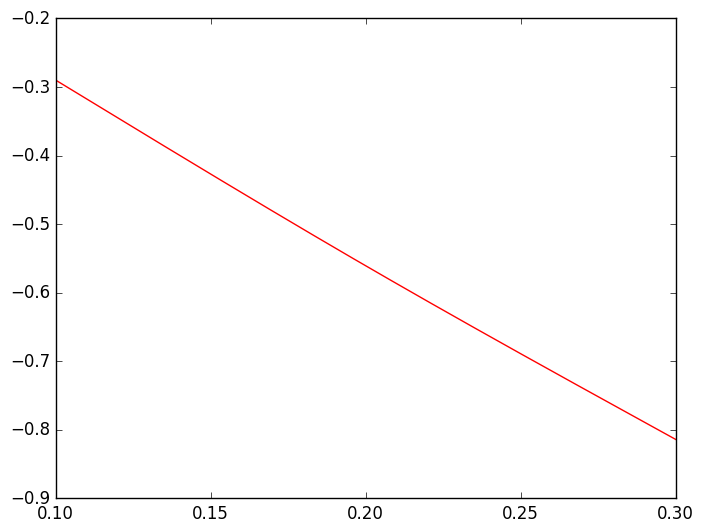

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f56a6addc10>

In [5]:
using PyPlot
x = linspace(data[1].x, data[end].x, 1000)
y = Vector(1000)
for i = 1 : 1000
    y[i] = Compute_cubic_spline(x[i], data, D_v)
end

plot(x, y, color="red", linewidth=1.0)

#### It looks like just a line, not a cubic spline.

#### How about (-1,0.5), (0,0), (3,3)?

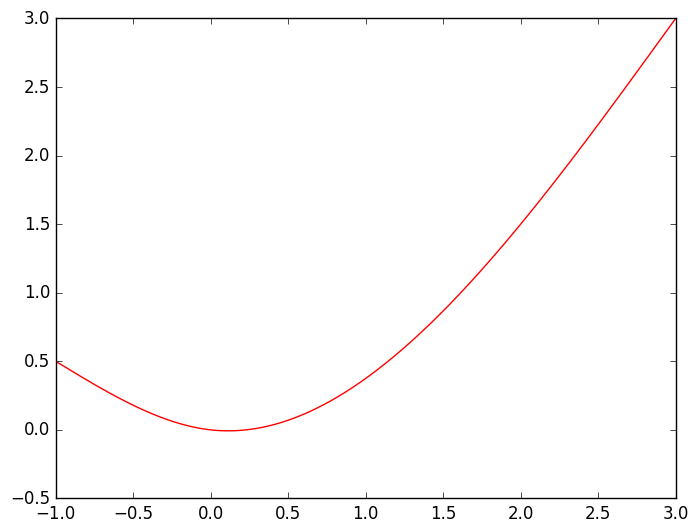

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f56a6a26350>

In [6]:
data = [Point(-1, 0.5), Point(0, 0), Point(3, 3)]

D_v = Compute_D_vector(data)

x = linspace(data[1].x, data[end].x, 1000)
y = Vector(1000)
for i = 1 : 1000
    y[i] = Compute_cubic_spline(x[i], data, D_v)
end

plot(x, y, color="red", linewidth=1.0)

### Cool. It works properly.

## Homework 2-2
<img src="./2-2.png">

#### In our lecture note, based on lagrange polynomial interpolation, three-point formulas is applied.

### lagrange ploynomial interpolation
<img src="./Equation 1.png">

In [7]:
# n-th Lagrange interpolating polynomial
function Lagrange(k::Int, x_::Float64, points::Array)
    n = length(points)
    lag = Float64(1)
    for i = 1 : n
        if i == k
            continue
        end
        lag *= (x_ - points[i].x)/(points[k].x - points[i].x)
    end
    
    return lag
end

# lagrange ploynomial interpolation
function interpolation(x_::Float64, points::Array)
    sum = 0
    n = length(points)
    
    for k = 1 : n
        sum += points[k].y*Lagrange(k, x_, points)
    end
    
    return sum
end

interpolation (generic function with 1 method)

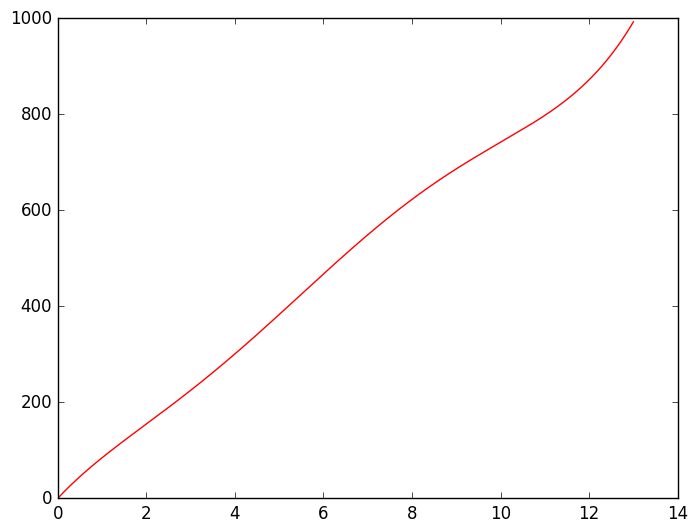

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f56a68f30d0>

In [8]:
# Problem data
data = [Point(0, 0), Point(3, 225), Point(5, 383), Point(8, 623), Point(10, 742), Point(13, 993)]

x = linspace(data[1].x, data[end].x, 1000)
y = Vector(1000)
for i = 1 : 1000
    y[i] = interpolation(x[i], data)
end

plot(x, y, color="red", linewidth=1.0)

###  three-point formulas
<img src="./Equation 2.png">

In [9]:
function three_point_d(x_::Float64, points::Array)
    
    small = 1e-7
    
    # If x_ equals boundary value, three-point fails.
    # Instead, forward difference or backward difference can be applied.
    if x_ == points[1].x
        return (interpolation(x_ + small, points) - interpolation(x_, points))/small
    elseif x_ == points[end].x
        return (interpolation(x_, points) - interpolation(x_ - small, points))/small
    else
        return (interpolation(x_ + small, points) - interpolation(x_ - small, points))/(2*small)
    end
end

three_point_d (generic function with 1 method)

### The speed of each point is the followings...

In [10]:
for i = 1 : length(data)
    println("f_prime(", data[i].x, ") = ", three_point_d(data[i].x, data))
end

f_prime(0.0) = 98.90247065227037
f_prime(3.0) = 72.56483570472483
f_prime(5.0) = 84.08736306364517
f_prime(8.0) = 68.81236231492949
f_prime(10.0) = 53.606501637659676
f_prime(13.0) = 156.64413353988493


## Homework 2-3
<img src="./2-3.png">

### First, let me inquire a exact solution to god-like Wolfram Alpha.

<img src="./Wolfram.png">

reference : https://www.wolframalpha.com/input/?i=definite+integral&rawformassumption=%7B%22F%22,+%22DefiniteIntegralCalculator%22,+%22integrand%22%7D+-%3E%22x%5E2*e%5E(-x)%22&rawformassumption=%7B%22F%22,+%22DefiniteIntegralCalculator%22,+%22variable%22%7D+-%3E%22x%22&rawformassumption=%7B%22F%22,+%22DefiniteIntegralCalculator%22,+%22rangestart%22%7D+-%3E%220%22&rawformassumption=%7B%22F%22,+%22DefiniteIntegralCalculator%22,+%22rangeend%22%7D+-%3E%221%22&rawformassumption=%7B%22C%22,+%22definite+integral%22%7D+-%3E+%7B%22Calculator%22%7D

In [11]:
exact_solution = 2 - 5*exp(-1)

0.16060279414278833

In [12]:
function equation(x::Float64)
    return (x^2) * exp(-x)
end

equation (generic function with 1 method)

### The three followings are each function of Trapezoidal, Simpson, and Gausian quadrature, respectiveley

In [13]:
function Trapezoidal(eq::Function, n::Int, interval::Tuple)
    h = (interval[2] - interval[1])/n

    sum = 0
    for i = 0 : (n-1)
        first = interval[1] + h*i
        last = interval[1] + h*(i+1)
        
        sum += (h/2)*(eq(first) + eq(last))
    end
    
    return sum
end

function Simpson(eq::Function, n::Int, interval::Tuple)
    h = (interval[2] - interval[1])/n

    sum = 0
    for i = 0 : (n-2)
        if i % 2 != 0
            continue
        end
        first = interval[1] + h*i
        mid = interval[1] + h*(i+1)
        last = interval[1] + h*(i+2)
        
        sum += (h/3)*(eq(first) + 4*eq(mid) + eq(last))
    end
    
    return sum
end

function Gausian(eq::Function, n::Int, interval::Tuple)
    # Linear coordinate transformation which makes Interval -> (-1, 1)
    function linear_trans(x::Float64, f_x::Function, interval::Tuple)
        return f_x(((interval[2]-interval[1])/2)*x + (interval[2]+interval[1])/2)*(interval[2]-interval[1])/2
    end
    
    # For n=2,
    #     c_1 = 1, c_2 = 1
    #     x_1 = -sqrt(3)/3, x_2 = sqrt(3)/3
    if n == 2
        return linear_trans(-sqrt(3)/3, eq, interval) + linear_trans(sqrt(3)/3, eq, interval) 
    end
end

Gausian (generic function with 1 method)

In [14]:
println("The exact solution : ", exact_solution)
println("\nUnder the condition n = 2...")
println("Trapezoidal Method : ", Trapezoidal(equation, 2, (0, 1)))
println("Simpson Method : ", Simpson(equation, 2, (0, 1)))
println("Gausian Quardrature : ", Gausian(equation, 2, (0, 1)))

The exact solution : 0.16060279414278833

Under the condition n = 2...
Trapezoidal Method : 0.16778619275693973
Simpson Method : 0.1624016834806793
Gausian Quardrature : 0.15941043096637894


### Let's compare error of each method.

In [15]:
println("Trapezoidal Method : ", abs(exact_solution - Trapezoidal(equation, 2, (0, 1))))
println("Simpson Method : ", abs(exact_solution - Simpson(equation, 2, (0, 1))))
println("Gausian Quardrature : ", abs(exact_solution - Gausian(equation, 2, (0, 1))))

Trapezoidal Method : 0.007183398614151404
Simpson Method : 0.0017988893378909632
Gausian Quardrature : 0.001192363176409389


### As known, absolute errors is...

### Gausian Quardrature < Simpson Method < Trapezoidal Method